## STA365 HW 1

#### Seo Won Yi (yiseo)
#### Collaborator: Serena Ban (banseri)

### Formulation of problem

Assume we have three vending machine (i.e., A, B, C).

Suppose each machine either takes money and gives out a product (i.e., success) or just eats the money (i.e., failure)

Problem: We want to figure out which machine has the highest probability of giving out a product

Assume that the following parameters are the true parameters for the vending machines that are unknown to us

In [1]:
# These parameters indicate the rate of success (that is, 
# the probability that a specific vending machine is actually working)

theta_A = 0.4 # probability of success for machine A
theta_B = 0.6 # probability of success for machine B
theta_C = 0.5 # probability of success for machine C

Since this question is about success or failure, we can assume the machines follow Bernoulli distributions (i.e., binomial distriubtion with fixed size parameter of 1).

Assume we do not have any prior knowledge about these machines.

We will use uninformative prior distribution (i.e., uniform distribution) which can be written as Beta distribution with parameter $\alpha = 1, \beta = 1$

To generalize and use the fact that binomial likelihood (or bernoulli) and beta prior results in beta posterior (which will be used as a new prior), I will use generic $\alpha, \beta$ for each prior for each machine's parameter to show how we can formulate our algorithm in an iterative way.

In other words, we have

$A_{success} \sim Bern(\theta_{A})$ (equivalent to $Binom(1, \theta_{A})$)

$B_{success} \sim Bern(\theta_{B})$ (equivalent to $Binom(1, \theta_{B})$)

$C_{success} \sim Bern(\theta_{C})$ (equivalent to $Binom(1, \theta_{C})$)

$\theta_{A} \sim Beta(\alpha_{A}, \beta_{A})$

$\theta_{B} \sim Beta(\alpha_{B}, \beta_{B})$

$\theta_{C} \sim Beta(\alpha_{C}, \beta_{C})$

Which means

$P(A|\theta_{A}) = \theta_{A}^{a}(1 - \theta_{A})^{1 - a}$

$P(B|\theta_{B}) = \theta_{B}^{b}(1 - \theta_{B})^{1 - b}$

$P(C|\theta_{C}) = \theta_{C}^{c}(1 - \theta_{A})^{1 - c}$

where a, b, c = 1 indicates success in machine A, B, C, respectively and a, b, c = 0 indicates failure in machine A, B, C.

Then, from the lecture we know that each posterior distribution would look like

$P(\theta_{A}|A) \propto \theta_{A}^{a + \alpha_{A} - 1}(1 - \theta_{A})^{1 - a + \beta_{A} - 1}$

$P(\theta_{B}|B) \propto \theta_{B}^{b + \alpha_{B} - 1}(1 - \theta_{B})^{1 - b + \beta_{B} - 1}$

$P(\theta_{C}|C) \propto \theta_{C}^{c + \alpha_{C} - 1}(1 - \theta_{C})^{1 - c + \beta_{C} - 1}$

Or we can write 

$\theta_{A}|A \sim Beta(\alpha = a + \alpha_{A}, \beta = 1 - a + \beta_{A})$

$\theta_{B}|B \sim Beta(\alpha = b + \alpha_{B}, \beta = 1 - b + \beta_{B})$

$\theta_{C}|C \sim Beta(\alpha = c + \alpha_{C}, \beta = 1 - c + \beta_{C})$

Now the algorithm I am going to implement works as follow:

1. simulate a sample from each posterior distribution
2. choose the machine which results in the maximum value
3. make a draw from the chosen machine 
4. observe success and failure for the drawn result then update the posterior distribution
5. repeat 1-4 until we see a "definite" winner

In the beginning we will use prior distributions to perform the task 1.

In this analysis, I am going to assume the definite winner can be decided if the same machine is selected 200 times in a row. 

In case where the true probabilities of the machines are similar, the algorithm may take a long time to run. In this case, we will simulate a sample from each posterior distribution after 50,000 iterations of update and choose the distribution that gives the maximum value for 10 times in a row as a winner.


In [2]:
from scipy import stats
import numpy as np

# set up the initial counter and winner
# when the counter reaches 200, we decide the "winner"
consecutive_winning_count = 0
winner = "A"
max_counter = 200


# set up initial alpha beta parameter for prior distributions of each machine
# we assume uninformative prior with each parameter = 1

alpha_A = 1
beta_A = 1
alpha_B = 1
beta_B = 1
alpha_C = 1
beta_C = 1

# count number of iterations and set up the maximum iteration to avoid run-time issue

num_iter = 0
num_max_iter = 50000


# functions that return result of a draw from each machine

def draw_from_A():
    return stats.binom(n=1, p=theta_A).rvs(size=1)[0]

def draw_from_B():
    return stats.binom(n=1, p=theta_B).rvs(size=1)[0]

def draw_from_C():
    return stats.binom(n=1, p=theta_C).rvs(size=1)[0]

# return new alpha and beta parameter values given the draw value

def update_posterior_parameter(alpha, beta, draw):
    if draw == 1:
        return alpha + 1, beta
    else:
        return alpha, beta + 1

# while there is no definite winner do the following

while consecutive_winning_count < max_counter and num_iter < num_max_iter:
    
    # simulate one from each posterior distribution
    
    A_sim = stats.beta(a=alpha_A, b=beta_A).rvs(size=1)[0]
    B_sim = stats.beta(a=alpha_B, b=beta_B).rvs(size=1)[0]
    C_sim = stats.beta(a=alpha_C, b=beta_C).rvs(size=1)[0]
    
    # perform argmax (get index of the maximum)
    
    maximum_simulated = np.argmax([A_sim, B_sim, C_sim])
    
    # draw one from the machine with the max value
    # if the winner did not change from the past, update the counter
    # otherwise, reset the counter and update the winner
    
    if maximum_simulated == 0:
        alpha_A, beta_A = update_posterior_parameter(alpha_A, beta_A, draw_from_A())
        if winner == "A":
            consecutive_winning_count += 1
        else:
            consecutive_winning_count = 1
            winner = "A"
        
    if maximum_simulated == 1:
        alpha_B, beta_B = update_posterior_parameter(alpha_B, beta_B, draw_from_B())
        if winner == "B":
            consecutive_winning_count += 1
        else:
            consecutive_winning_count = 1
            winner = "B"
            
    if maximum_simulated == 2:
        alpha_C, beta_C = update_posterior_parameter(alpha_C, beta_C, draw_from_C())
        if winner == "C":
            consecutive_winning_count += 1
        else:
            consecutive_winning_count = 1
            winner = "C"
    num_iter += 1

# if maximum iteration has been reached
# decide winner if any simulation results in 10 consecutive maximum value
if num_iter == num_max_iter:
    consecutive_winning_count = 0
    winner = "A"
    alternative_max_win_count = 10
    
    while consecutive_winning_count < alternative_max_win_count:
        A_sim = stats.beta(a=alpha_A, b=beta_A).rvs(size=1)[0]
        B_sim = stats.beta(a=alpha_B, b=beta_B).rvs(size=1)[0]
        C_sim = stats.beta(a=alpha_C, b=beta_C).rvs(size=1)[0]

        # perform argmax (get index of the maximum) and update posterior

        maximum_simulated = np.argmax([A_sim, B_sim, C_sim])
        if maximum_simulated == 0:
            alpha_A, beta_A = update_posterior_parameter(alpha_A, beta_A, draw_from_A())
            if winner == "A":
                consecutive_winning_count += 1
            else:
                consecutive_winning_count = 1
                winner = "A"

        if maximum_simulated == 1:
            alpha_B, beta_B = update_posterior_parameter(alpha_B, beta_B, draw_from_B())
            if winner == "B":
                consecutive_winning_count += 1
            else:
                consecutive_winning_count = 1
                winner = "B"

        if maximum_simulated == 2:
            alpha_C, beta_C = update_posterior_parameter(alpha_C, beta_C, draw_from_C())
            if winner == "C":
                consecutive_winning_count += 1
            else:
                consecutive_winning_count = 1
                winner = "C"
        num_iter += 1
    

The number of iteration needed to perform this algorithm is as follow:

In [3]:
num_iter

1614

According to the algorithm, the machine that we should always pick is the following:

In [4]:
winner

'B'

Finally, we can check the posterior distributions to confirm how confident we can be about our choice of the machine

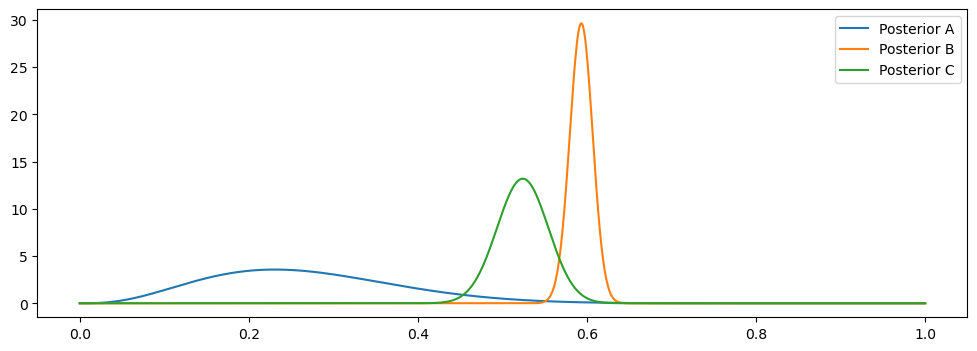

In [5]:
import matplotlib.pyplot as plt
parameter_domain = np.linspace(0,1,1001)
posterior_A = stats.beta(a=alpha_A, b=beta_A).pdf(parameter_domain)
posterior_B = stats.beta(a=alpha_B, b=beta_B).pdf(parameter_domain)
posterior_C = stats.beta(a=alpha_C, b=beta_C).pdf(parameter_domain)

plt.figure(figsize=(12,4))
plt.plot(parameter_domain, posterior_A, label="Posterior A")
plt.plot(parameter_domain, posterior_B, label="Posterior B")
plt.plot(parameter_domain, posterior_C, label="Posterior C")
plt.legend()
plt.show()


We can observe that the overlaps of the posterior distributions are small, and the posterior distribution of the winner machine has very low variance from the mean. Thus, we can be somewhat confident regarding our choice of the machine.

We can repeat the entire experiment 50 times to observe the accuracy of the algorithm with random theta's

In [6]:
# repeat the experiment 50 times with random theta_A, theta_B, theta_C
# we will calculate how much time our algorithm guesses the winner correctly

import random
import time


# number of times we are going to run the entire experiment

num_exp = 50

# count the correct guesses
correct_guesses = 0

# set the maximum iterations per experiment

num_max_iter = 50000


# copy the past code and repeat the experiment num_exp times

start = time.time()

for i in range(num_exp):
    # randomly generate theta's
    theta_A = round(random.random(), 3)
    theta_B = round(random.random(), 3)
    theta_C = round(random.random(), 3)  
    
    # avoid duplicate winner scenario
    epsilon = 0.001
    
    while abs(theta_A - theta_B) < epsilon or abs(theta_A - theta_C) < epsilon \
    or abs(theta_B - theta_C) < epsilon:
        print(f"Chosen theta_A is {theta_A}")
        print(f"Chosen theta_B is {theta_B}")
        print(f"Chosen theta_C is {theta_C}")
        print("Processing recomputation of theta's to avoid duplicate winner")
        theta_A = round(random.random(), 3)
        theta_B = round(random.random(), 3)
        theta_C = round(random.random(), 3)  
    print(f"Final theta_A is {theta_A}")
    print(f"Final theta_B is {theta_B}")
    print(f"Final theta_C is {theta_C}")
    
    # record the original "winner"
    orig_winner = np.argmax([theta_A, theta_B, theta_C])
    
    # set up the prior
    alpha_A = 1
    beta_A = 1
    alpha_B = 1
    beta_B = 1
    alpha_C = 1
    beta_C = 1
    
    # set up the counter and initial winner
    consecutive_winning_count = 0
    winner = 0
    
    # set up the winning criteria (200 consecutive selections)
    max_counter = 200
    
    # count number of iterations
    num_iter = 0

    while consecutive_winning_count < max_counter and num_iter < num_max_iter:

        # simulate one from each posterior distribution

        A_sim = stats.beta(a=alpha_A, b=beta_A).rvs(size=1)[0]
        B_sim = stats.beta(a=alpha_B, b=beta_B).rvs(size=1)[0]
        C_sim = stats.beta(a=alpha_C, b=beta_C).rvs(size=1)[0]

        # perform argmax (get index of the maximum)

        maximum_simulated = np.argmax([A_sim, B_sim, C_sim])

        # draw one from the machine with the max value
        # if the winner did not change from the past, update the counter
        # otherwise, reset the counter and update the winner

        if maximum_simulated == 0:
            alpha_A, beta_A = update_posterior_parameter(alpha_A, beta_A, draw_from_A())
            if winner == 0:
                consecutive_winning_count += 1
            else:
                consecutive_winning_count = 1
                winner = 0

        if maximum_simulated == 1:
            alpha_B, beta_B = update_posterior_parameter(alpha_B, beta_B, draw_from_B())
            if winner == 1:
                consecutive_winning_count += 1
            else:
                consecutive_winning_count = 1
                winner = 1

        if maximum_simulated == 2:
            alpha_C, beta_C = update_posterior_parameter(alpha_C, beta_C, draw_from_C())
            if winner == 2:
                consecutive_winning_count += 1
            else:
                consecutive_winning_count = 1
                winner = 2
        num_iter += 1
        
    if num_iter == num_max_iter:
        consecutive_winning_count = 0
        winner = 0
        alternative_max_win_count = 10

        while consecutive_winning_count < alternative_max_win_count:
            A_sim = stats.beta(a=alpha_A, b=beta_A).rvs(size=1)[0]
            B_sim = stats.beta(a=alpha_B, b=beta_B).rvs(size=1)[0]
            C_sim = stats.beta(a=alpha_C, b=beta_C).rvs(size=1)[0]

            # perform argmax (get index of the maximum)

            maximum_simulated = np.argmax([A_sim, B_sim, C_sim])
            if maximum_simulated == 0:
                alpha_A, beta_A = update_posterior_parameter(alpha_A, beta_A, draw_from_A())
                if winner == 0:
                    consecutive_winning_count += 1
                else:
                    consecutive_winning_count = 1
                    winner = 0

            if maximum_simulated == 1:
                alpha_B, beta_B = update_posterior_parameter(alpha_B, beta_B, draw_from_B())
                if winner == 1:
                    consecutive_winning_count += 1
                else:
                    consecutive_winning_count = 1
                    winner = 1

            if maximum_simulated == 2:
                alpha_C, beta_C = update_posterior_parameter(alpha_C, beta_C, draw_from_C())
                if winner == 2:
                    consecutive_winning_count += 1
                else:
                    consecutive_winning_count = 1
                    winner = 2
    if winner == 0:
        print("Winner is A")
    elif winner == 1:
        print("Winner is B")
    elif winner == 2:
        print("Winner is C")
            
    if winner == orig_winner:
        correct_guesses += 1
        print("Guess is correct!")
    else:
        print("Guess is wrong!")
        
    print(f"Progress {round((i+1) * 100/50)}% done")
        
end = time.time()

print(f"The accuracy of our algorithm is {correct_guesses/num_exp * 100}%") 
print(f"The algorithm took {round(end - start, 3)} seconds in total")

Final theta_A is 0.732
Final theta_B is 0.337
Final theta_C is 0.246
Winner is A
Guess is correct!
Progress 2% done
Final theta_A is 0.056
Final theta_B is 0.795
Final theta_C is 0.954
Winner is C
Guess is correct!
Progress 4% done
Final theta_A is 0.001
Final theta_B is 0.596
Final theta_C is 0.653
Winner is C
Guess is correct!
Progress 6% done
Final theta_A is 0.465
Final theta_B is 0.136
Final theta_C is 0.591
Winner is C
Guess is correct!
Progress 8% done
Final theta_A is 0.736
Final theta_B is 0.62
Final theta_C is 0.84
Winner is C
Guess is correct!
Progress 10% done
Final theta_A is 0.91
Final theta_B is 0.911
Final theta_C is 0.147
Winner is B
Guess is correct!
Progress 12% done
Final theta_A is 0.243
Final theta_B is 0.486
Final theta_C is 0.143
Winner is B
Guess is correct!
Progress 14% done
Final theta_A is 0.787
Final theta_B is 0.77
Final theta_C is 0.137
Winner is A
Guess is correct!
Progress 16% done
Final theta_A is 0.365
Final theta_B is 0.762
Final theta_C is 0.75
Winn

We can confirm that our algorithm performs extremely well.